### Encoder-Decoder model

In this notebook we discuss encoder-decoder model for sequence to sequence classification task. Encoder-Decoder network uses two subnetworks -

* Encoder encoded input text into hidden representation
* Decoder reads hidden representation from encoder and the hidden state from previous decoder output and predict the output for next timestep

In this notebook we fit a encoder-decoder model to predict the next sentence given the previous sentence. So, given a sequence of integer token ids, our model predicts another sequence of token ids. Our intention is to build a generative model that can generate new sentences given some input.

FYI - in this model the length of input sequence and output sequence are not same.

In [115]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

pd.options.display.max_colwidth = -1
pd.options.display.max_rows = 1000

### Data Processing

We use the clinical notes data. In each clinical notes we have multiple lines written. We split the text into multiple inputs and outputs. Our objective is to predict the next sentence given all the previous sentences. We keep only sentences having more than 10 words and less than 50 words.

In [2]:
data = pd.read_csv('./clinical_notes_cleaned.csv')

In [3]:
data.head(5)

text  \
0  \n \n \n \n \n <B>CC:</B> Difficulty with word finding.\n \n <B>HX: </B>This 27y/o RHF experienced sudden onset word finding difficulty and slurred speech on the evening of 2/19/96. She denied any associated dysphagia, diplopia, numbness or weakness of her extremities. She went to sleep with her symptoms on 2/19/96, and awoke with them on 2/20/96. She also awoke with a headache (HA) and mild neck stiffness. She took a shower and her HA and neck stiffness resolved. Throughout the day she continued to have difficulty with word finding and had worsening of her slurred speech. That evening, she began to experience numbness and weakness in the lower right face. She felt like there was a &quot;rubber-band&quot; wrapped around her tongue.\n \n For 3 weeks prior to presentation, she experienced transient episodes of a &quot;boomerang&quot; shaped field cut in the left eye. The episodes were not associated with any other symptoms. One week prior to presentation, she went to a local ER for menorrhagia. She had just resumed taking oral birth control pills one week prior to the ER visit after having stopped their use for several months. Local evaluation included an unremarkable carotid duplex scan. However, a HCT with and without contrast reportedly revealed a left frontal gyriform enhancing lesion. An MRI brain scan on 2/20/96 revealed nonspecific white matter changes in the right periventricular region. EEG reportedly showed diffuse slowing. CRP was reportedly &quot;too high&quot; to calibrate.\n \n <B>MEDS:</B> Ortho-Novum 7-7-7 (started 2/3/96), and ASA (started 2/20/96).\n \n <B>PMH:</B> 1)ventral hernia repair 10 years ago, 2)mild &quot;concussion&quot; suffered during a MVA; without loss of consciousness, 5/93, 3) Anxiety disorder, 4) One childbirth.\n \n <B>FHX: </B>She did not know her father and was not in contact with her mother.\n \n <B>SHX:</B> Lives with boyfriend. Smokes one pack of cigarettes every three days and has done so for 10 years. Consumes 6 bottles of beers, one day a week. Unemployed and formerly worked at an herbicide plant.\n \n <B>EXAM: </B>BP150/79, HR77, RR22, 37.4C.\n \n MS: A&O to person, place and time. Speech was dysarthric with mild decreased fluency marked by occasional phonemic paraphasic errors. Comprehension, naming and reading were intact. She was able to repeat, though her repetition was occasionally marked by phonemic paraphasic errors. She had no difficulty with calculation.\n \n CN: VFFTC, Pupils 5/5 decreasing to 3/3. EOM intact. No papilledema or hemorrhages seen on fundoscopy. No RAPD or INO. There was right lower facial weakness. Facial sensation was intact, bilaterally. The rest of the CN exam was unremarkable.\n \n MOTOR: 5/5 strength throughout with normal muscle bulk and tone.\n \n Sensory: No deficits.\n \n Coord/Station/Gait: unremarkable.\n \n Reflexes 2/2 throughout. Plantar responses were flexor, bilaterally.\n \n Gen Exam: unremarkable.\n \n <B>COURSE:</B> CRP 1.2 (elevated), ESR 10, RF 20, ANA 1:40, ANCA &lt;1:40, TSH 2.0, FT4 1.73, Anticardiolipin antibody IgM 10.8GPL units (normal &lt;10.9), Anticardiolipin antibody IgG 14.8GPL (normal&lt;22.9), SSA and SSB were normal. Urine beta-hCG pregnancy and drug screen were negative. EKG, CXR and UA were negative.\n \n MRI brain, 2/21/96 revealed increased signal on T2 imaging in the periventricular white matter region of the right hemisphere. In addition, there were subtle T2 signal changes in the right frontal, right parietal, and left parietal regions as seen previously on her local MRI can. In addition, special FLAIR imaging showed increased signal in the right frontal region consistent with ischemia.\n \n She underwent Cerebral Angiography on 2/22/96. This revealed decreased flow and vessel narrowing the candelabra branches of the RMCA supplying the right frontal lobe. These changes corresponded to the areas of ischemic changes seen on MRI. There was also segmental narrowing of the caliber of the vessels in the circle of

In [20]:
max_length = 50
min_length = 10

In [34]:
inputs = []
outputs = []

data = data.fillna('')

for text in data.clean_text:
    text = text.split(' . ')
    text = [t.strip() for t in text]
    #text = [t for t in text if len(t.split()) >= min_length and len(t.split()) <= max_length]
    
    for i in range(len(text)-1):
        #input_token = "[CLS] " + " ".join(" . ".join(text[:i+1]).split()[:max_length-2]) + " [SEP]"
        #output_token = "[CLS] " + " ".join(text[i+1].split())[:max_length-2] + " [SEP]"
        input_token = " ".join(" . ".join(text[:i+1]).split()[:max_length-2])
        output_token = " ".join(text[i+1].split())[:max_length-2]
        inputs.append(input_token)
        outputs.append(output_token)

In [35]:
len(inputs), len(outputs)

(31329, 31329)

In [36]:
df = pd.DataFrame()
df['input_text'] = inputs
df['output_text'] = outputs

df = df.drop_duplicates(subset=['input_text']).reset_index(drop=True)

In [37]:
df.head(100)

,input_text,output_text
0,difficulty word find,27y / rhf experience sudden onset word find diff
1,difficulty word find . 27y / rhf experience sudden onset word find difficulty slurred speech evening 2/19/96,"deny associate dysphagia , diplopia , numbness w"
2,"difficulty word find . 27y / rhf experience sudden onset word find difficulty slurred speech evening 2/19/96 . deny associate dysphagia , diplopia , numbness weakness extremity","go sleep symptom 2/19/96 , awake 2/20/96"
3,"difficulty word find . 27y / rhf experience sudden onset word find difficulty slurred speech evening 2/19/96 . deny associate dysphagia , diplopia , numbness weakness extremity . go sleep symptom 2/19/96 , awake 2/20/96",also awake headache ha mild neck stiffness
4,"difficulty word find . 27y / rhf experience sudden onset word find difficulty slurred speech evening 2/19/96 . deny associate dysphagia , diplopia , numbness weakness extremity . go sleep symptom 2/19/96 , awake 2/20/96 . also awake headache ha mild neck stiffness",take shower ha neck stiffness resolve
5,"difficulty word find . 27y / rhf experience sudden onset word find difficulty slurred speech evening 2/19/96 . deny associate dysphagia , diplopia , numbness weakness extremity . go sleep symptom 2/19/96 , awake 2/20/96 . also awake headache ha mild neck stiffness . take shower ha neck",throughout day continue difficulty word finding
6,preoperative ganglion left wrist,postoperative ganglion left wrist
7,preoperative ganglion left wrist . postoperative ganglion left wrist,excision ganglion
8,preoperative ganglion left wrist . postoperative ganglion left wrist . excision ganglion,general
9,preoperative ganglion left wrist . postoperative ganglion left wrist . excision ganglion . general,estimate blood less 5 ml


In [27]:
print (df.shape)

(4947, 2)


In [28]:
from sklearn.model_selection import KFold

In [38]:
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(df.input_text,df.output_text):
    break
    
train = df.iloc[train_index].reset_index(drop=True)
val = df.iloc[val_index].reset_index(drop=True)

### Model Hyperparameter

We use a simple 1-layer Bidirectional GRU encoder and 1-layer bidirectional GRU decoder.

In [88]:
BATCH_SIZE = 32
EPOCHS = 25
embed_dim = 200 #dimension of the embedding
lstm_out = 100 #dimension of the lstm output 
MAX_NB_WORDS = 10000

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Input, LSTM, Embedding, Dense, Conv1D, TimeDistributed, Dropout, Bidirectional, BatchNormalization, GlobalAveragePooling1D, SpatialDropout1D
#from keras_contrib.layers import CRF
from tensorflow.keras.callbacks import EarlyStopping

### Tokenization

We tokenize both the input and output texts using keras tokenizer. We only keep top 10000 words. Unknown words are replaced with UNK token. Further, we use zero padding to convert all the input and output texts into fixed length.

In [39]:
tokenizer = Tokenizer(oov_token='UNK', num_words=MAX_NB_WORDS+1)
tokenizer.fit_on_texts(train.input_text)
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= MAX_NB_WORDS+1}

word2idx = tokenizer.word_index
word2idx["PAD"] = 0 # Padding

In [41]:
word2idx["CLS"] = max(list(word2idx.values())) + 1
word2idx["SEP"] = word2idx["CLS"] + 1

Also, in encoder-decoder model we need to have tokens to denote start and end of each text. We use CLS token to denote start of a sentence and SEP to denote end of a sentence. These 2 tokens are appended in the front and the back for all the input and output texts. 

While decoding, we start with the CLS token in the decoder output and incrementally predict the whole output sentence.

In [44]:
trainX = tokenizer.texts_to_sequences(train.input_text)
trainX = [[word2idx["CLS"]] + i + [word2idx["SEP"]] for i in trainX]
trainX = pad_sequences(maxlen=max_length, sequences=trainX, padding="post", value=word2idx["PAD"])

trainy = tokenizer.texts_to_sequences(train.output_text)
trainy = [[word2idx["CLS"]] + i + [word2idx["SEP"]] for i in trainy]
trainy = pad_sequences(maxlen=max_length, sequences=trainy, padding="post", value=word2idx["PAD"])

valX = tokenizer.texts_to_sequences(val.input_text)
valX = [[word2idx["CLS"]] + i + [word2idx["SEP"]] for i in valX]
valX = pad_sequences(maxlen=max_length, sequences=valX, padding="post", value=word2idx["PAD"])

valy = tokenizer.texts_to_sequences(val.output_text)
valy = [[word2idx["CLS"]] + i + [word2idx["SEP"]] for i in valy]
valy = pad_sequences(maxlen=max_length, sequences=valy, padding="post", value=word2idx["PAD"])

trainX = np.array(trainX)
trainy = np.array(trainy)
valX = np.array(valX)
valy = np.array(valy)

#trainy = to_categorical(trainy)
#valy = to_categorical(valy)

print (trainX.shape, valX.shape, trainy.shape, valy.shape)

(3957, 50) (990, 50) (3957, 50) (990, 50)


### Embeddings

We use PubMed word embeddings in both encoder and decoder. 

In [48]:
embeddings_index = {}
f = open('pubmed_wv.txt','r',encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if coefs.shape[0] == embed_dim and word in word2idx:
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2665548it [08:37, 5152.56it/s] 

Found 3881 word vectors.


In [49]:
idx2word = {i:w for (w,i) in word2idx.items()}

In [50]:
embedding_matrix = np.zeros((len(word2idx), embed_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Model Architecture

As mentioned earlier, we use 1-layer GRU in encoder. Similarly, decoder contains 1-layer GRU followed by the output layer. We pass the encoded states to decoder as input. Further, we use attention mechanism between encoder and decoder.

#### Attention

Attention is a mechanism to enable decoder attain only an area high relevance in encoder output during decoding. We use Bahdanau style attention. The below image shows the importance of attention in the context of neural machine translation.

In attention, we denote the encoder hidden representation as <b>key</b> and <b>value</b> and we denote the decoder representation as <b>query</b>. We want to learn the updated <b>value</b> for each decoder step by aligning <b>key</b> and <b>query</b>.

<img src=https://blog.floydhub.com/content/images/2019/09/Slide36.JPG>

With attention, our model looks like - 

<img src=https://blog.floydhub.com/content/images/2019/09/Slide38.JPG>

In [51]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

#### How attention scores are calculated

<img src=https://blog.floydhub.com/content/images/2019/09/Slide50.JPG>

In [52]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values))) #step 1, 2 and 3 of above diagram

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1) #step 4

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values #step 5
        context_vector = tf.reduce_sum(context_vector, axis=1) #step 5

        return context_vector, attention_weights

In [53]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) #step 6 of above diagram

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

We use categorical cross entropy as loss function

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

Bleu score is an evaluation metric mostly used for evaluating NMT. It uses ngram based counts to evaluate predicted sequence.

In [56]:
import collections
import math


def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.
    Args:
        segment: text segment from which n-grams will be extracted.
        max_order: maximum length in tokens of the n-grams returned by this
        methods.
    Returns:
        The Counter containing all n-grams upto max_order in segment
        with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i+order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
    """Computes BLEU score of translated segments against one or more references.
    Args:
        reference_corpus: list of lists of references for each translation. Each
        reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
        should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.
    Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram)-1] += overlap[ngram]
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

    precisions = [0] * max_order
    for i in range(0, max_order):
        if smooth:
            precisions[i] = ((matches_by_order[i] + 1.) /
                           (possible_matches_by_order[i] + 1.))
        else:
            if possible_matches_by_order[i] > 0:
                precisions[i] = (float(matches_by_order[i]) /
                             possible_matches_by_order[i])
            else:
                precisions[i] = 0.0

    if min(precisions) > 0:
        p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0

    ratio = float(translation_length) / reference_length

    if ratio > 1.0:
        bp = 1.
    else:
        bp = math.exp(1 - 1. / ratio)

    bleu = geo_mean * bp

    return (bleu, precisions, bp, ratio, translation_length, reference_length)

Training function. Our decoder starts with CLS token and uses teacher forcing during inference. Decoder runs till the end of the output sentence is hitted.

#### Teacher forcing

Teacher forcing is a strategy for training recurrent neural networks that uses model output from a prior time step as an input. Hence, during training the encoder-decoder model we feed the correct previous decoder output instead of decoder predicted output to the decoder. 

It's like when a teacher shares some hint with his student to rectify his mistakes in order to make him learn faster.

<img src=https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/12/What-is-Teacher-Forcing-for-Recurrent-Neural-Networks.jpg>

Below illustration shows the importance of teacher forcing. Actual output is "two people running".

<img src="https://miro.medium.com/max/842/1*U3d8D_GnfW13Y3nDgvwJSw.png" width="270">

In [74]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([word2idx['CLS']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [75]:
@tf.function
def eval_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([word2idx['CLS']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss

We convert the training and validation data into tensorflow dataset

In [60]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainy))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [61]:
steps_per_epoch = len(trainX)//BATCH_SIZE

In [62]:
example_input_batch, example_target_batch = next(iter(train_dataset))
print (example_input_batch.shape, example_target_batch.shape)

(32, 50) (32, 50)


In [63]:
encoder = Encoder(len(word2idx), embed_dim, lstm_out, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (32, 50, 100)
Encoder Hidden state shape: (batch size, units) (32, 100)


In [64]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 100)
Attention weights shape: (batch_size, sequence_length, 1) (32, 50, 1)


In [65]:
decoder = Decoder(len(word2idx), embed_dim, lstm_out, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 3939)


In [66]:
print (encoder.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  787800    
_________________________________________________________________
gru (GRU)                    multiple                  90600     
Total params: 878,400
Trainable params: 90,600
Non-trainable params: 787,800
_________________________________________________________________
None


In [67]:
print (decoder.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  787800    
_________________________________________________________________
gru_1 (GRU)                  multiple                  120600    
_________________________________________________________________
dense_3 (Dense)              multiple                  397839    
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  20301     
Total params: 1,326,540
Trainable params: 538,740
Non-trainable params: 787,800
_________________________________________________________________
None


In [68]:
eval_dataset = tf.data.Dataset.from_tensor_slices((valX, valy))
eval_dataset = eval_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [69]:
steps_per_epoch_eval = len(valX)//BATCH_SIZE

In [70]:
print (steps_per_epoch, steps_per_epoch_eval)

123 30


### Model Checkpointing

Model checkpointing is used to store the model weights so that the model can pick up where it left off in the previous training process.

In [71]:
model_dir = "./seq2seq_exp1"

try:
  os.makedirs(model_dir)
except:
  print ("folder exists")

In [72]:
checkpoint_dir = '{}/training_checkpoints'.format(model_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Model Training and Evaluation

During training after each epoch we calculate the cross entropy loss between decoder output and actual output. We calculate average loss on both training as well as validation dataset.

During inference, decoder waits till it predicts the SEP token. Once SEP token or the maximum output length is reached, decoding stops.

In [89]:
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_eval_loss = 0
    current_best_eval_loss = 2*steps_per_epoch_eval #.50 * steps_per_epoch_eval

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
      
    eval_enc_hidden = [tf.zeros((BATCH_SIZE, lstm_out))]
    for (batch, (inp, targ)) in enumerate(eval_dataset.take(steps_per_epoch_eval)):
        batch_loss = eval_step(inp, targ, eval_enc_hidden)
        total_eval_loss += batch_loss

    # saving (checkpoint) the model every 2 epochs
    if total_eval_loss < current_best_eval_loss:
        encoder.save_weights('{}/encoder.h5'.format(model_dir))
        decoder.save_weights('{}/decoder.h5'.format(model_dir))
        current_best_eval_loss = total_eval_loss
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Train Loss {:.4f} and Test Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch,total_eval_loss / steps_per_epoch_eval))
  
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 0.5824
Epoch 1 Batch 100 Loss 0.6172
Epoch 1 Train Loss 0.5774 and Test Loss 0.5925
Time taken for 1 epoch 67.65565824508667 sec

Epoch 2 Batch 0 Loss 0.5662
Epoch 2 Batch 100 Loss 0.6015
Epoch 2 Train Loss 0.5634 and Test Loss 0.5885
Time taken for 1 epoch 68.52380657196045 sec

Epoch 3 Batch 0 Loss 0.5506
Epoch 3 Batch 100 Loss 0.5876
Epoch 3 Train Loss 0.5492 and Test Loss 0.5837
Time taken for 1 epoch 68.00229096412659 sec

Epoch 4 Batch 0 Loss 0.5359
Epoch 4 Batch 100 Loss 0.5697
Epoch 4 Train Loss 0.5357 and Test Loss 0.5787
Time taken for 1 epoch 67.73110723495483 sec

Epoch 5 Batch 0 Loss 0.5220
Epoch 5 Batch 100 Loss 0.5480
Epoch 5 Train Loss 0.5229 and Test Loss 0.5751
Time taken for 1 epoch 66.74630808830261 sec

Epoch 6 Batch 0 Loss 0.5102
Epoch 6 Batch 100 Loss 0.5334
Epoch 6 Train Loss 0.5101 and Test Loss 0.5731
Time taken for 1 epoch 68.88494181632996 sec

Epoch 7 Batch 0 Loss 0.4967
Epoch 7 Batch 100 Loss 0.5190
Epoch 7 Train Loss 0.4984 and Test L

In [90]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
encoder.load_weights('{}/encoder.h5'.format(model_dir))
decoder.load_weights('{}/decoder.h5'.format(model_dir))

In [91]:
def evaluate(sentence):
    len_in = trainX.shape[1]
    len_out = trainy.shape[1]
    attention_plot = np.zeros((len_out,len_in))

    #sentence = preprocess_sentence(sentence)

    #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    #inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
    #                                                       maxlen=max_length_inp,
    #                                                       padding='post')
    inputs = tf.convert_to_tensor(sentence)

    result = ''

    hidden = [tf.zeros((1, lstm_out))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([word2idx['CLS']], 0)

    for t in range(len_out):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += idx2word[predicted_id] + ' '

        if idx2word[predicted_id] == 'SEP':
            return result, sentence,attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

### Model Inspection

As discussed previously, attention weights can be used to understand the alignment between input and output texts. We plot attention weights for few test examples.

In [106]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

Predicted clean text: 
 patient present patient state remember anything SEP 
Original output: 
 27y / rhf experience sudden onset word find diff


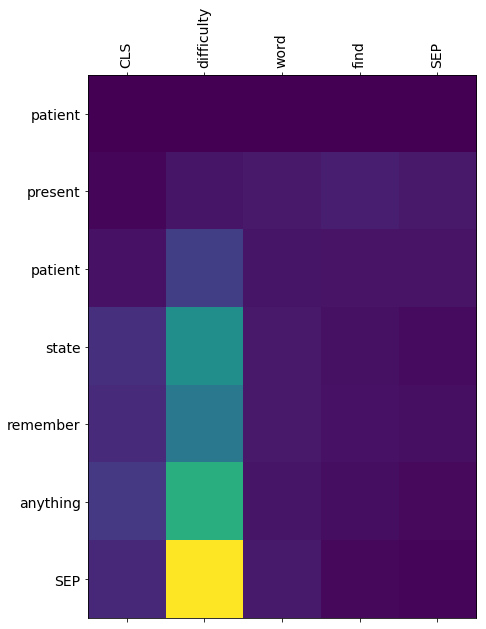

In [134]:
test_id = 0
result, sentence, attention_plot = evaluate(valX[test_id:test_id+1])
actual = val.output_text.iloc[test_id:test_id+1].values

print ("Predicted clean text: \n", result)
print ("Original output: \n", actual[0])
#print ("Bleu score: \n", compute_bleu([result],[actual[0].split()])[0])

result = result.split()
sentence = ['CLS'] + val.input_text.iloc[test_id:test_id+1].values[0].split() + ['SEP']
attention_plot = attention_plot[:len(result), :len(sentence)]
plot_attention(attention_plot, sentence, result)

Predicted clean text: 
 deny chest pain SEP 
Original output: 
 deny associate dysphagia , diplopia , numbness w


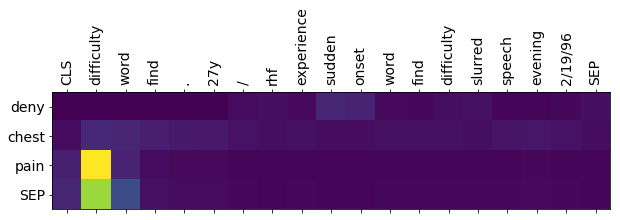

In [135]:
test_id = 1
result, sentence, attention_plot = evaluate(valX[test_id:test_id+1])
actual = val.output_text.iloc[test_id:test_id+1].values

print ("Predicted clean text: \n", result)
print ("Original output: \n", actual[0])
#print ("Bleu score: \n", compute_bleu([result],[actual[0].split()])[0])

result = result.split()
sentence = ['CLS'] + val.input_text.iloc[test_id:test_id+1].values[0].split() + ['SEP']
attention_plot = attention_plot[:len(result), :len(sentence)]
plot_attention(attention_plot, sentence, result)

Predicted clean text: 
 symptom worsen considerable UNK UNK SEP 
Original output: 
 go sleep symptom 2/19/96 , awake 2/20/96


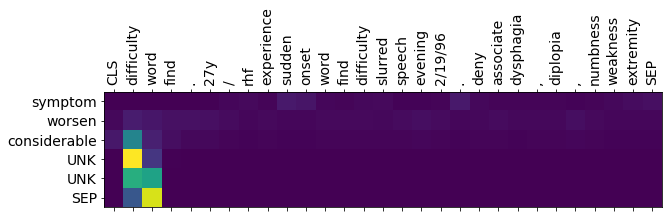

In [136]:
test_id = 2
result, sentence, attention_plot = evaluate(valX[test_id:test_id+1])
actual = val.output_text.iloc[test_id:test_id+1].values

print ("Predicted clean text: \n", result)
print ("Original output: \n", actual[0])
#print ("Bleu score: \n", compute_bleu([result],[actual[0].split()])[0])

result = result.split()
sentence = ['CLS'] + val.input_text.iloc[test_id:test_id+1].values[0].split() + ['SEP']
attention_plot = attention_plot[:len(result), :len(sentence)]
plot_attention(attention_plot, sentence, result)

In this notebook we demonstrate the power of encoder-decoder model in sequence to sequence classification. Seq2Seq is much harder task than simple classification tasks. It requires much larger training dataset and more number of training interations to achieve comparable result.

### Reference

1. https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

2. https://blog.floydhub.com/attention-mechanism/

3. https://www.tensorflow.org/tutorials/text/nmt_with_attention

4. https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/